In [392]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import statsmodels.api as sm
import pickle
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.dates import date2num
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline
import json
plt.close("all")

import sys
!{sys.executable} -m pip install statsmodels

euroData = pd.read_csv("data\euro_countries_filled.csv")
with open("data/iso_country_codes.json", "r") as read_file:
    countryCodes = json.load(read_file)

warnings.filterwarnings("ignore")

## Creating Datasets

In [393]:
def country_set(iso_code, smoothed = False, beg_date='2020-01-01', end_date=euroData["date"].iloc[-1]):
    """For specific country.
    :param iso_code: The county's ISO-code (3 letters)
    :param smoothed: True->Uses new_cases_smoothed as the source for new cases (7-day average)
                     False->Uses raw data from new_cases
    :param beg_date: beginning of the dataset
    :param end_date: end of the dataset   
    """
    if (smoothed):
        df = euroData[euroData.iso_code==iso_code].groupby("date")["new_cases_smoothed_per_million"].sum().reset_index(name = "new_cases_per_million")
    else:
        df = euroData[euroData.iso_code==iso_code].groupby("date")["new_cases_per_million"].sum().reset_index(name = "new_cases_per_million")
        
    df['date'] = pd.to_datetime(df['date'])
    # Set the date as index 
    df = df.set_index('date')
    # Select the proper time period for weekly aggreagation
    df = df[beg_date:end_date]
    return df

In [394]:
euroData

,Unnamed: 0,iso_code,location,date,new_cases,new_cases_smoothed,new_cases_per_million,new_cases_smoothed_per_million,population,new_tests,new_tests_smoothed,stringency_index,latitude,longitude
0,0,ALB,Albania,2019-12-31,0.0,0.000,0.000,0.000,2877800.0,0.0,0.0,0.00,41.0,20.0
1,1,ALB,Albania,2020-01-01,0.0,0.000,0.000,0.000,2877800.0,0.0,0.0,0.00,41.0,20.0
2,2,ALB,Albania,2020-01-02,0.0,0.000,0.000,0.000,2877800.0,0.0,0.0,0.00,41.0,20.0
3,3,ALB,Albania,2020-01-03,0.0,0.000,0.000,0.000,2877800.0,0.0,0.0,0.00,41.0,20.0
4,4,ALB,Albania,2020-01-04,0.0,0.000,0.000,0.000,2877800.0,0.0,0.0,0.00,41.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10487,10487,UKR,Ukraine,2020-11-18,11968.0,11208.571,273.656,256.291,43733759.0,42862.0,41017.0,61.57,49.0,32.0
10488,10488,UKR,Ukraine,2020-11-19,12496.0,11477.857,285.729,262.448,43733759.0,40585.0,40110.0,61.57,49.0,32.0
10489,10489,UKR,Ukraine,2020-11-20,13357.0,11806.429,305.416,269.961,43733759.0,NaN,NaN,61.57,49.0,32.0
10490,10490,UKR,Ukraine,2020-11-21,29155.0,14287.571,666.647,326.694,43733759.0,NaN,NaN,61.57,49.0,32.0


## Visualizing the data 

In [ ]:
df_nor = country_set("NOR")
df_esp = country_set("ESP")
df_deu = country_set("DEU")

In [318]:
def Initial_plot(df, country_name):
    y = df['new_cases_per_million']
    fig, ax = plt.subplots(figsize=(20, 6))
    plt.title("Number of Daily New Cases of COVID-19 in " + country_name)
    ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Daily')
    ax.plot(y.resample('W').mean(),marker='o', markersize=8, linestyle='-', label='Weakly Mean Resample')
    ax.set_ylabel('Daily New Cases of COVID-19 in '+country_name)
    ax.legend();

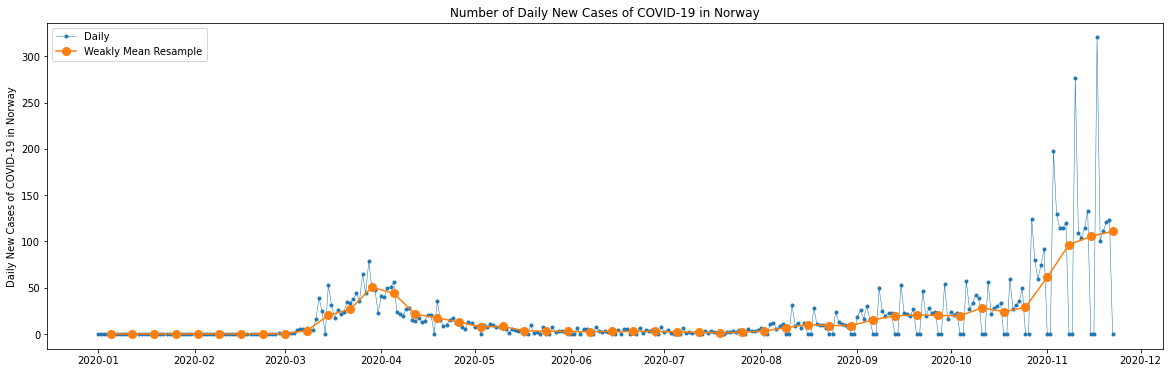

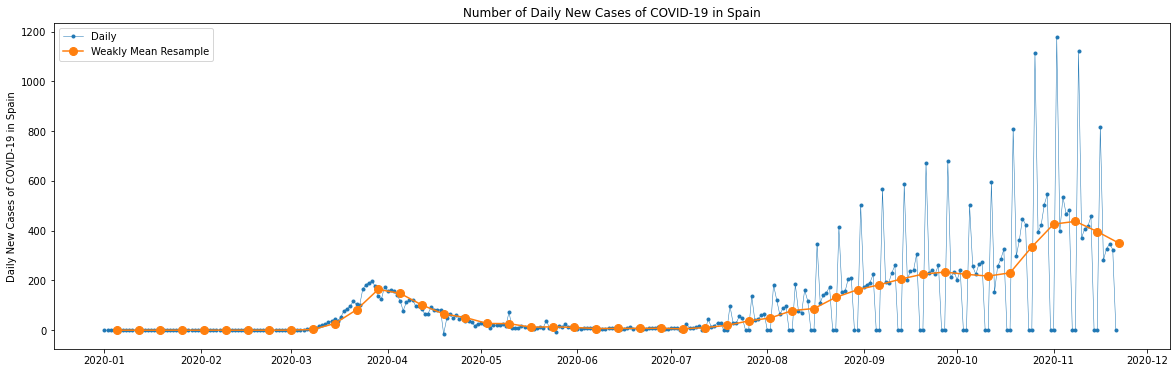

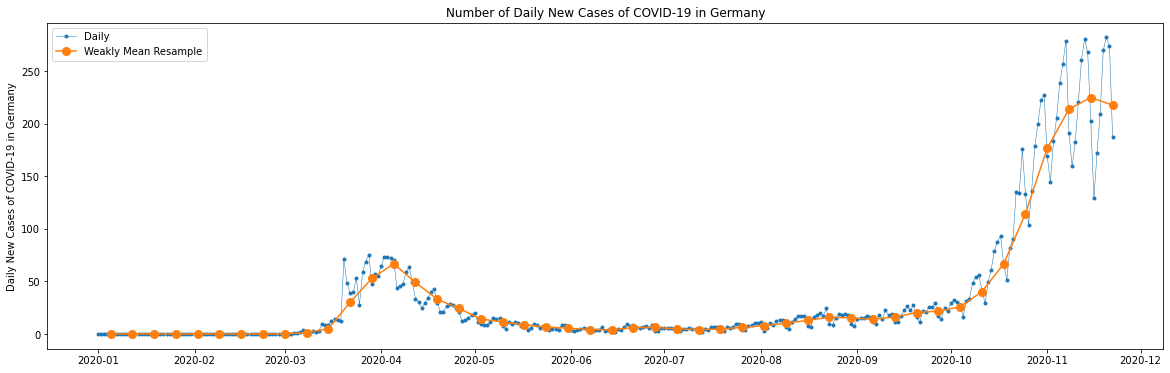

In [319]:
Initial_plot(df_nor, country_name = 'Norway')
Initial_plot(df_esp, country_name = 'Spain')
Initial_plot(df_deu, country_name = 'Germany')

### Decomposing the data

Into Trend, Season and Residual

In [320]:
def seasonal_decompose(y, country_name):
    """For specific country.
    :param y: dataseries
    :param country_name: for the heading  
    """
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,14)
    fig.suptitle("Decomposition of the Time Series of COVID-19 Cases in " + country_name, fontsize=16)
    plt.show()


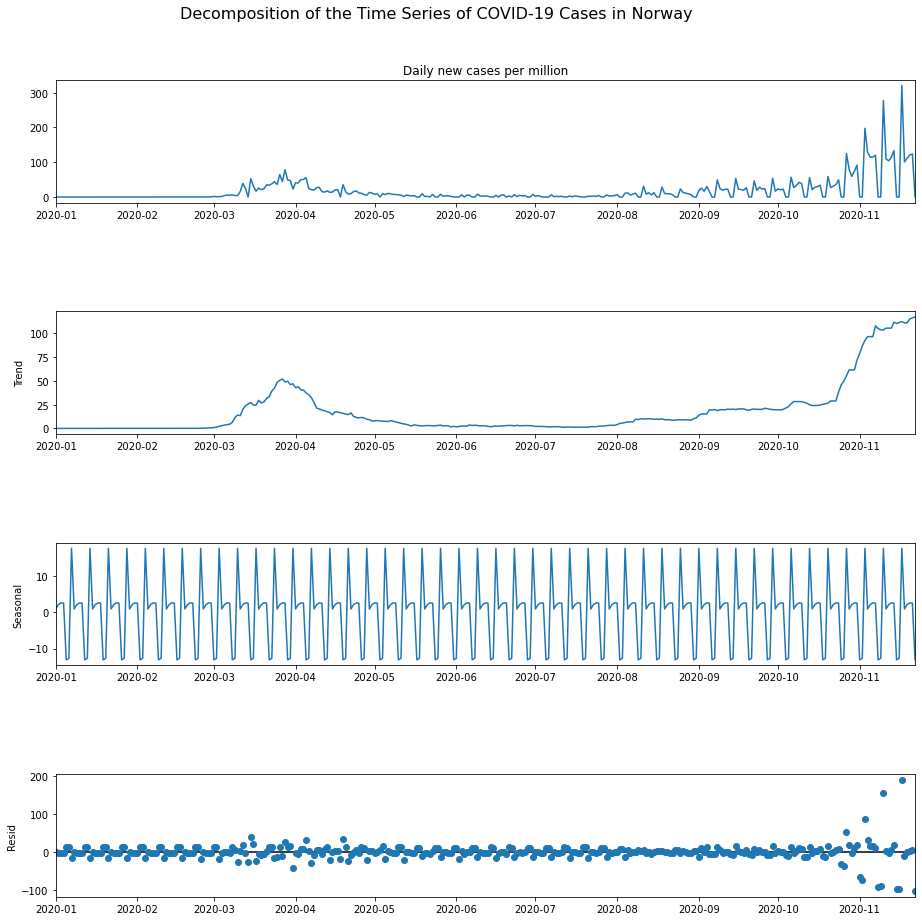

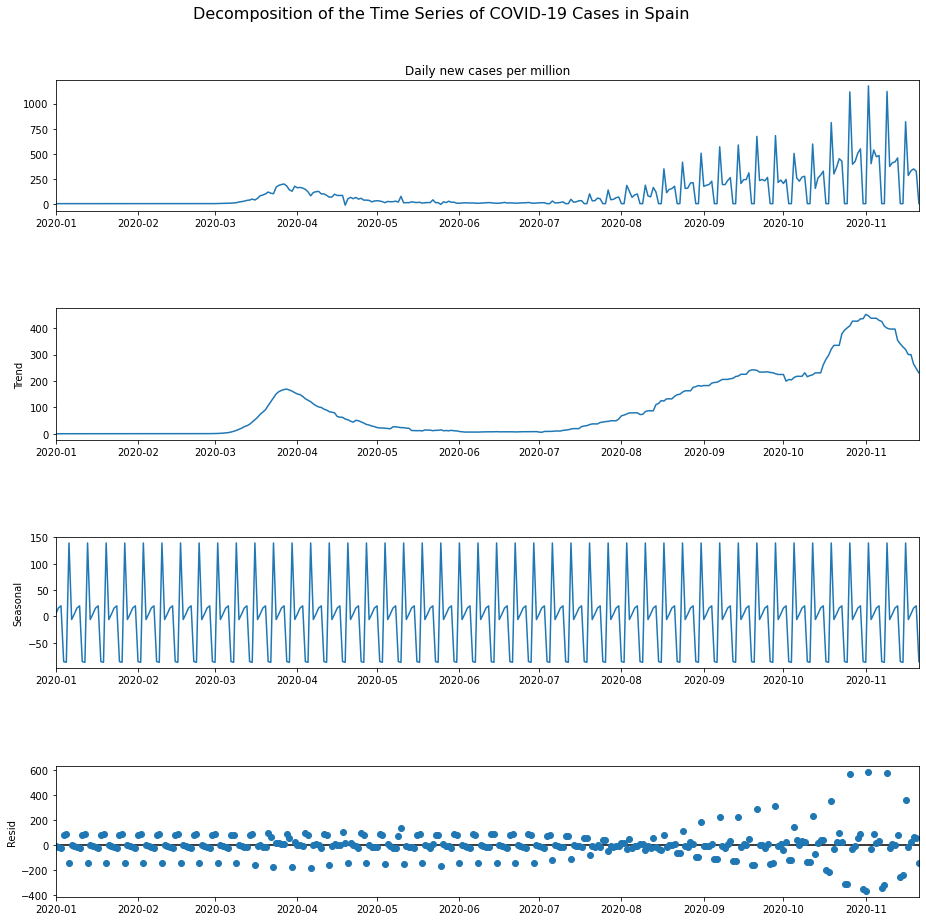

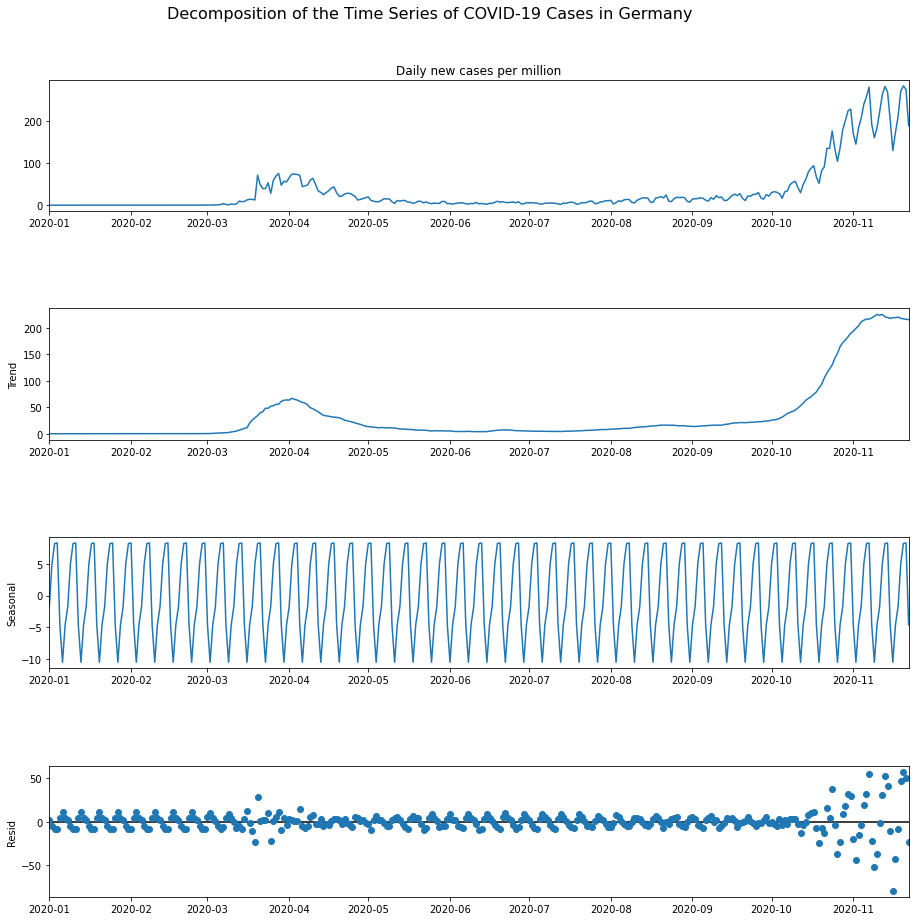

In [321]:
y_nor = df_nor['new_cases_per_million'].rename("Daily new cases per million")
y_esp = df_esp['new_cases_per_million'].rename("Daily new cases per million")
y_deu = df_deu['new_cases_per_million'].rename("Daily new cases per million")

seasonal_decompose(y_nor, country_name ='Norway')
seasonal_decompose(y_esp, country_name ='Spain')
seasonal_decompose(y_deu, country_name ='Germany')


## Creating Forecasts

In [352]:
def country_forecasts(iso_cd = None, smoothed = False, \
                      s_date='2020-01-01',train_e_date='2020-10-31', test_s_date = '2020-11-01', e_date='2020-11-07'):
    """Creating forecasts for specific country.
    ES methods: Holt Linear, Holt-Winters-Additive and Holt-Winters-Additive Dampened
    
    :param iso_code: The county's ISO-code (3 letters)
    :param smoothed: True->Uses new_cases_smoothed as the source for new cases (7-day average)
                     False->Uses raw data from new_cases
    :param s_date: beginning of the entire dataset
    :param train_e_date: ending of training part of the set
    :param test_s_date: start of test part of set
    :param e_date: end of the entire dataset
    
    :return y: Pandas Series containing the actual reported data
    :return *method*_forecast: Pandas Series containing the forecast based on the given method
    :return results:Dataframe containing hyperparameters and error
    """
    df = country_set(smoothed=smoothed, iso_code=iso_cd, end_date=e_date)
    
    name = iso_cd
        
    y = df['new_cases_per_million'].rename('Actual Reported Data')
    y = y[s_date:]
    y_to_train = y[:train_e_date]
    
    # dataset to train
    y_to_test = y[test_s_date:] # last X months for test
    predict_date = len(y) - len(y_to_train) 
    
    #Holt Linear
    holt_lin_fit = Holt(y_to_train).fit(optimized=True)
    holt_lin_forecast = holt_lin_fit.forecast(predict_date).rename("Holt's Linear")
    mse_holt_lin = (np.square(holt_lin_forecast - y_to_test)).mean()
    
    #Holt-Winters-Additive
    holtw_ad_fit = ExponentialSmoothing(y_to_train, seasonal_periods=7, trend='add', seasonal='add').fit(optimized=True)
    holtw_ad_forecast = holtw_ad_fit.forecast(predict_date).rename("Holt-Winter's Additive")
    mse_holtw_ad = (np.square(holtw_ad_forecast - y_to_test)).mean()
    
    #Holt-Winters-Additive Dampened
    holtw_ad_damp_fit = ExponentialSmoothing(y_to_train, seasonal_periods = 7, trend='add', seasonal='add', damped=True).fit(optimized=True)
    holtw_ad_damp_forecast = holtw_ad_damp_fit.forecast(predict_date).rename("Holt-Winter's Additive+Damped")
    mse_holtw_ad_damp = (np.square(holtw_ad_damp_forecast - y_to_test)).mean()
    
    params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'initial_level', 'initial_trend', 'smoothing_seasonal']
    results=pd.DataFrame(index=[r"Smooth. Lvl ($\alpha$)",r"Smooth. Trend ($\beta$)",r"Damp. Trend ($\phi$)",\
                                r"Initial Lvel ($l_0)$","Initial Trend ($b_0)$",r"Season Smoothing ($\gamma$)",\
                                "Mean Squared Error"] ,\
                         columns=["Holt's Linear","Holt-Winter's Additive","Holt-Winter's Additive + Damped"])
    results["Holt's Linear"] = [format(holt_lin_fit.params[p],".2f") for p in params] + [format(mse_holt_lin, ".2f")] 
    results["Holt-Winter's Additive"] = [format(holtw_ad_fit.params[p],".2f") for p in params] + [format(mse_holtw_ad, ".2f")]
    results["Holt-Winter's Additive + Damped"] = [format(holtw_ad_damp_fit.params[p],".2f") for p in params] + [format(mse_holtw_ad_damp, ".2f")]
    
    return y, holt_lin_forecast, holtw_ad_forecast, holtw_ad_damp_forecast, mse_holt_lin, mse_holtw_ad, mse_holtw_ad_damp, results
    

## Plotting Forecasts

In [353]:

def plot_methods(iso_code, smoothed=False, s_date='2020-01-01',train_e_date='2020-10-31',\
                 test_s_date = '2020-11-01', e_date='2020-11-07', plot_start = '2020-10-10'):
    """Plotting the different forecasting methods.
    ES methods: Holt Linear, Holt-Winters-Additive and Holt-Winters-Additive Dampened
    
    :param iso_code: The county's ISO-code (3 letters)
    :param smoothed: True->Uses new_cases_smoothed as the source for new cases (7-day average)
                     False->Uses raw data from new_cases
    :param s_date: beginning of the entire dataset
    :param train_e_date: ending of training part of the set
    :param test_s_date: start of test part of set
    :param e_date: end of the entire dataset
    :param plot_start: start of plot
    """
    y, holt_lin_forecast,\
    holtw_ad_forecast, \
    holtw_ad_damp_forecast, \
    mse_holt_lin, mse_holtw_ad, mse_holtw_ad_damp, \
    results = country_forecasts(iso_cd=iso_code, smoothed=smoothed, \
                                    s_date=s_date,train_e_date=train_e_date, test_s_date=test_s_date, e_date=e_date)
    smoothed_txt=""
    if (smoothed == True):
        smoothed_txt += " (Smoothed)"
        
    y.plot(marker='o', color='black', legend="Actual Number of Cases", figsize=(14, 7), xlim=(plot_start,e_date))
        
    holt_lin_forecast.plot(style='--', marker='o', color='red', legend=True, xlim=(plot_start,e_date))
    holtw_ad_forecast.plot(style='--', marker='o', color='green', legend=True, xlim=(plot_start,e_date))
    holtw_ad_damp_forecast.plot(style='--', marker='o', color='blue', legend=True, xlim=(plot_start,e_date))
        
    plt.title("Comparison of different Exponential Smoothing methods - "+ iso_code +smoothed_txt)
    plt.ylim(0, None)
    plt.axvspan(test_s_date, '2020-11-08' , alpha=0.1, color='grey' )
    plt.xlim(plot_start, '2020-11-08')
    plt.ylabel("Daily new COVID-19 cases per million")
    plt.xlabel("Date")
        
    display(results)
    

In [369]:

def error_estimate(smoothed=True, s_date='2020-01-01',train_e_date='2020-10-31',\
                 test_s_date = '2020-11-01', e_date='2020-11-07', plot_start = '2020-10-10'):
    
    iso_codes = euroData["iso_code"].unique()
    mse_holt_lin = 0
    mse_holtw_ad = 0 
    mse_holtw_ad_damp = 0
    
    for iso_code in iso_codes:
        y, holt_lin_forecast,\
        holtw_ad_forecast, \
        holtw_ad_damp_forecast, \
        mse_1, mse_2, mse_3, \
        results = country_forecasts(iso_cd=iso_code, smoothed=smoothed, \
                                    s_date=s_date,train_e_date=train_e_date, test_s_date=test_s_date, e_date=e_date)
        print(iso_code," = ", mse_3)
        
        mse_holt_lin += mse_1
        mse_holtw_ad += mse_2
        mse_holtw_ad_damp+= mse_3
    
    
    print("MSE Holt-Winter's Additive + Damped = ", mse_holtw_ad_damp)
    print("MSE Holt-Winter's Additive = ", mse_holtw_ad)
    print("MSE Holt Linear = ", mse_holt_lin)
    print("RMSE Holt-Winter's Additive + Damped = ", np.sqrt(mse_holtw_ad_damp))





In [370]:
error_estimate()

ALB  =  134.8537404765335
AUT  =  121.28979024558907
BEL  =  40546.588894477565
BGR  =  543.1814288626513
BIH  =  4897.651837866972
BLR  =  42.765283042770115
CHE  =  35794.86030955212
CZE  =  1009.7146501437832
DEU  =  317.26863244338716
DNK  =  20.739643959275224
ESP  =  669.295381043287
EST  =  406.8291589518455
FIN  =  1.085881484087397
FRA  =  1938.6557266856532
GRC  =  478.39344960175094
HRV  =  14632.168348768839
HUN  =  484.46048903281763
ITA  =  1461.9228139269628
LTU  =  979.5509084820659
LVA  =  84.82873511820154
MDA  =  25.624561585226246
NLD  =  7799.453522316798
NOR  =  72.29954695183658
POL  =  952.7736668068184
PRT  =  2008.4056764950103
ROU  =  1631.6757954390753
RUS  =  15.772815063003861
SRB  =  121.71104753212649
SVK  =  7402.50022881831
SVN  =  71574.7982370975
SWE  =  227.48765414986448
UKR  =  360.2879717806041
MSE Holt-Winter's Additive + Damped =  196758.8958282023
MSE Holt-Winter's Additive =  201167.72083655812
MSE Holt Linear =  146820.31543662987
RMSE Holt-

In [356]:
error_estimate(smoothed=False)

MSE Holt-Winter's Additive + Damped =  705235.4280633483
MSE Holt-Winter's Additive =  781628.3506393875
MSE Holt Linear =  2480767.714384982
RMSE Holt-Winter's Additive + Damped =  839.782964856604


In [391]:
def predictions_to_csv( iso_codes ):
    df = pd.DataFrame()
    i = 0
    for iso_code in iso_codes:
        y, holt_lin_forecast,\
        holtw_ad_forecast, \
        holtw_ad_damp_forecast, \
        mse_holt_lin, mse_holtw_ad, mse_holtw_ad_damp, \
        results = country_forecasts(iso_cd=iso_code, smoothed=True)
        
        frame = {'Holt-Winter Additive + Damped ' + iso_code : holtw_ad_damp_forecast}
        if (i==0):
            df = pd.DataFrame(frame)
            i=1
        else:
            df['Holt-Winter Additive + Damped ' + iso_code ] = holtw_ad_damp_forecast.values
        df.to_csv("predictions\hw_predictions.csv")
    return df
    

In [388]:
a=predictions_to_csv(['NOR', 'SWE', 'FIN', 'BEL'])
a

,Holt-Winter Additive + Damped NOR,Holt-Winter Additive + Damped SWE,Holt-Winter Additive + Damped FIN,Holt-Winter Additive + Damped BEL
2020-11-01,44.616171,302.134830,38.401278,764.898206
2020-11-02,48.329234,266.442765,38.636291,234.030889
2020-11-03,131.505685,194.900924,36.968443,1466.812797
2020-11-04,89.558068,269.928506,44.159645,1621.097434
2020-11-05,82.697988,396.365078,40.211447,1253.832923
2020-11-06,90.741554,465.777160,42.191954,1051.504680
2020-11-07,94.614322,392.349160,39.882205,1246.307789


,Holt's Linear,Holt-Winter's Additive,Holt-Winter's Additive + Damped
Smooth. Lvl ($\alpha$),1.00,0.76,0.77
Smooth. Trend ($\beta$),1.00,0.76,0.77
Damp. Trend ($\phi$),nan,nan,0.99
Initial Lvel ($l_0)$,0.00,39.92,39.92
Initial Trend ($b_0)$,0.00,0.02,0.02
Season Smoothing ($\gamma$),nan,0.24,0.23
Mean Squared Error,29782.66,75425.75,71574.80


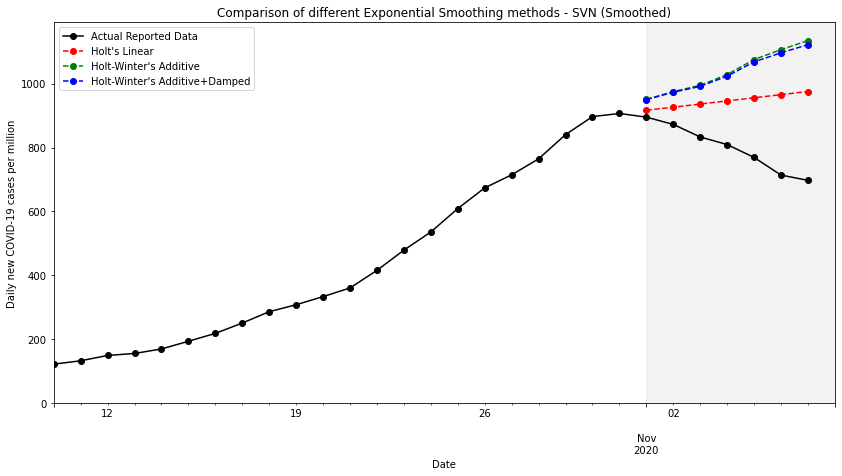

In [387]:
plot_methods('SVN', smoothed=True)

,Holt's Linear,Holt-Winter's Additive,Holt-Winter's Additive + Damped
Smooth. Lvl ($\alpha$),1.00,1.00,1.00
Smooth. Trend ($\beta$),0.81,0.80,0.99
Damp. Trend ($\phi$),nan,nan,0.88
Initial Lvel ($l_0)$,0.00,37.70,37.69
Initial Trend ($b_0)$,0.00,-0.11,-0.08
Season Smoothing ($\gamma$),nan,0.00,0.00
Mean Squared Error,520.68,470.11,227.49


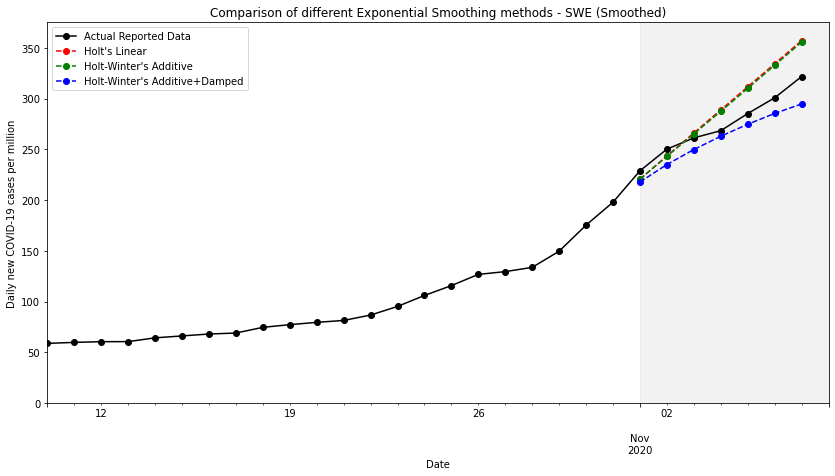

In [382]:
plot_methods('SWE', smoothed=True)

,Holt's Linear,Holt-Winter's Additive,Holt-Winter's Additive + Damped
Smooth. Lvl ($\alpha$),0.99,0.30,0.30
Smooth. Trend ($\beta$),0.00,0.17,0.17
Damp. Trend ($\phi$),nan,nan,0.99
Initial Lvel ($l_0)$,-0.00,30.20,30.21
Initial Trend ($b_0)$,1.08,-0.00,0.00
Season Smoothing ($\gamma$),nan,0.70,0.70
Mean Squared Error,15560.50,5197.72,5179.01


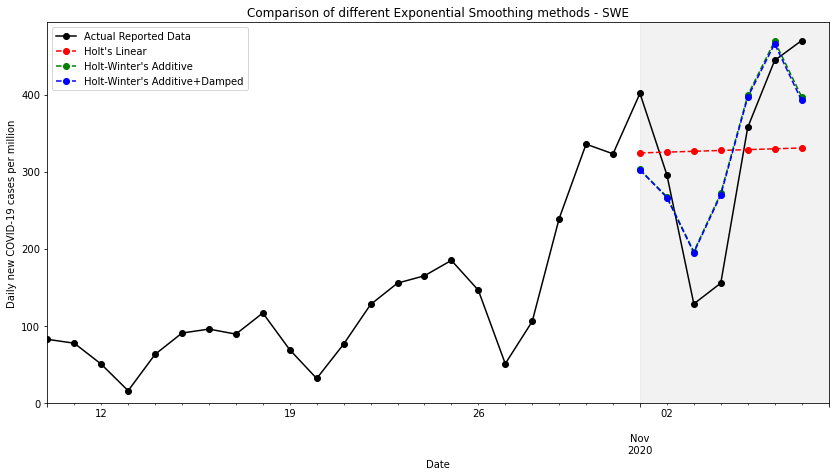

In [390]:
plot_methods('SWE', smoothed=False)

,Holt's Linear,Holt-Winter's Additive,Holt-Winter's Additive + Damped
Smooth. Lvl ($\alpha$),1.00,0.80,0.80
Smooth. Trend ($\beta$),0.96,0.80,0.80
Damp. Trend ($\phi$),nan,nan,0.97
Initial Lvel ($l_0)$,0.00,110.23,110.95
Initial Trend ($b_0)$,0.00,-0.31,-0.37
Season Smoothing ($\gamma$),nan,0.20,0.20
Mean Squared Error,28480.68,33089.32,40546.59


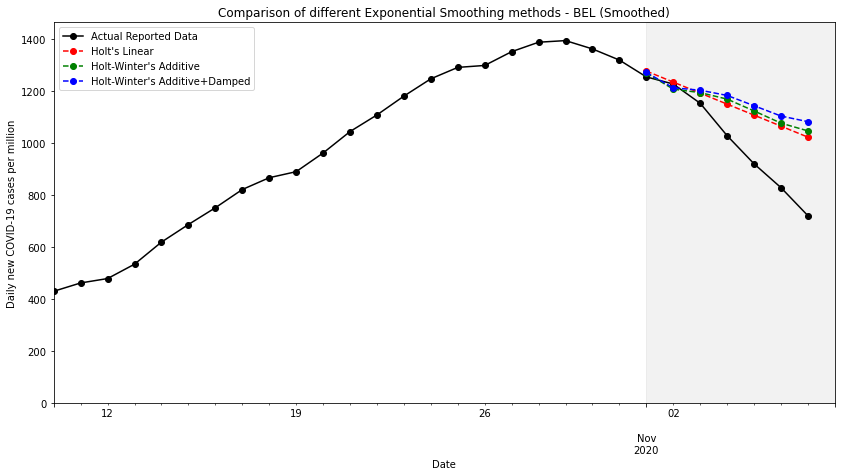

In [384]:
plot_methods('BEL', smoothed=True)

,Holt's Linear,Holt-Winter's Additive,Holt-Winter's Additive + Damped
Smooth. Lvl ($\alpha$),0.83,0.82,0.81
Smooth. Trend ($\beta$),0.60,0.62,0.63
Damp. Trend ($\phi$),nan,nan,0.99
Initial Lvel ($l_0)$,0.00,18.15,18.15
Initial Trend ($b_0)$,0.00,-0.08,-0.08
Season Smoothing ($\gamma$),nan,0.00,0.00
Mean Squared Error,366.20,350.24,317.27


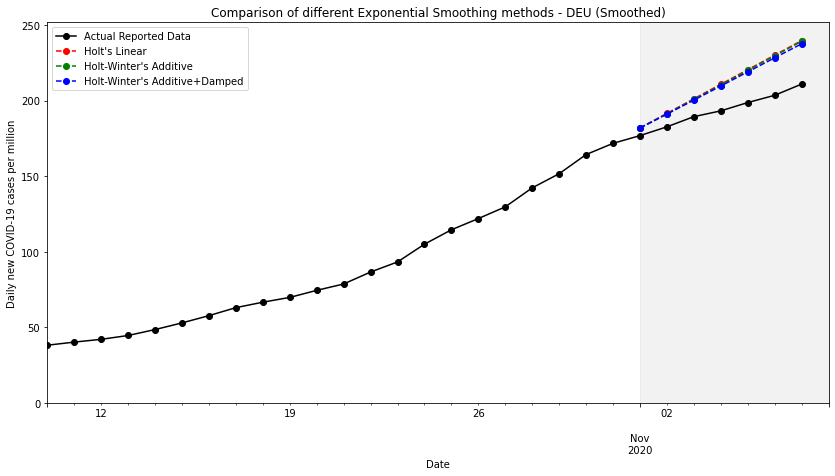

In [364]:
plot_methods('DEU', smoothed=True)